In [15]:
import numpy as np
import statsmodels.api as sm
from scipy.stats import t
import pandas as pd
from scipy.stats import t
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from scipy.stats import t


In [16]:
################ futher help func ####################
# 假设你有一个方差-协方差矩阵V
def invsqrtmatrix(V):
    eigenvalues, eigenvectors = np.linalg.eig(V)
    D_sqrt = np.diag(np.sqrt(eigenvalues))
    V_sqrt = eigenvectors @ D_sqrt @ np.linalg.inv(eigenvectors)
    return np.linalg.inv(V_sqrt)
# invsqrtmatrix(Dm)


import numpy as np
from scipy.stats import norm
from scipy.optimize import brentq

def equation(a, alpha, k=1):
    return  1 - (1 - 2 * (1 + a * norm.pdf(a) - norm.cdf(a))) ** k  - (alpha)

def solve_for_a(alpha):
    a_low = -10
    a_high = 10
    a = brentq(equation, a_low, a_high, args=(alpha,))
    return a

alpha = 0.1
a = solve_for_a(alpha)
print(a)

2.5002777108094048


In [3]:
np.random.seed(47)
ar_param = 0.5
ma_param = 0.6
N = 2

In [4]:
from tqdm import tqdm
countfail = 0
serx = 0
sery = 1
m = 200
q = 3
n_samples = q * m + 5
selected_lag_order = 3 # see

In [5]:
bondtable = np.full(q*m, np.nan, dtype=np.float32)
def bondary_func(m, n, a=2.795):
    part1 = np.sqrt(m)
    part2 = (n - m) / m
    part3 = (n / (n - m)) * (a**2 + np.log(n / (n - m)))
    part4 = np.sqrt(part3)
    result = part1 * part2 * part4
    return result

for n in range(m+1, q*m):
    bondtable[n] = bondary_func(m, n, a)

In [6]:
## update way
for _ in tqdm(range(3000)):
    
    f_t = np.random.normal(size=n_samples)
    alphas = np.random.uniform(low=0.1, high=1.0, size=N)
    u_it = np.random.normal(size=(n_samples, N))
    correlated_errors = f_t[:, np.newaxis] * alphas[np.newaxis,:] + u_it
    series_list=[]

    for i in range(N):
        arma_model = sm.tsa.ArmaProcess(ar=np.r_[1,-ar_param], ma=np.r_[1, ma_param])
        series = arma_model.generate_sample(nsample=n_samples, scale=1, distrvs=lambda size: correlated_errors[:size[0], i])
        series_list.append(series)
    df = (np.array(series_list, dtype=np.float32).T)
    model_VAR = VAR(df)
    results = model_VAR.fit(selected_lag_order)
    residuals = results.resid
    break
    y = residuals[:m, sery]
    x = residuals[:m, serx]
    x_with_const = sm.add_constant(x)
    model = sm.OLS(y, x_with_const).fit() 
    beta_m = model.params[1]
    Dm = model.cov_params()[1][1] * m


    for n in range(m+1, q*m):
        y = residuals[:n, sery]
        x = residuals[:n, serx]
        x_with_const = sm.add_constant(x)
        model_n = sm.OLS(y, x_with_const).fit()
        beta_n = model_n.params[1]
        Zn = n * (Dm)**(-1/2) * (beta_n - beta_m)
        if(np.abs(Zn)>bondtable[n]):
            countfail += 1
            break

  0%|                                                                                         | 0/3000 [00:00<?, ?it/s]


In [35]:
countfail

285

In [14]:
import numpy as np
import pandas as pd
from scipy.stats import jarque_bera
from statsmodels.tsa.stattools import adfuller, acf

# Example time series data
# Replace this with your actual time series data
time_series = residuals[:, 0]
# Jarque-Bera test
jb_stat, jb_p = jarque_bera(time_series)
print(f"Jarque-Bera test statistic: {jb_stat}, p-value: {jb_p}")

# Autocorrelation at lag 1 and lag 2
acf_values = acf(time_series, nlags=2)
lag1 = acf_values[1]
lag2 = acf_values[2]
print(f"Lag 1 autocorrelation: {lag1}")
print(f"Lag 2 autocorrelation: {lag2}")

# Augmented Dickey-Fuller test
adf_result = adfuller(time_series)
adf_stat = adf_result[0]
adf_p = adf_result[1]
print(f"ADF test statistic: {adf_stat}, p-value: {adf_p}")

Jarque-Bera test statistic: 1.6611958182757116, p-value: 0.43578864639594994
Lag 1 autocorrelation: 0.009516338382495005
Lag 2 autocorrelation: -0.032350158449482184
ADF test statistic: -12.635252317326783, p-value: 1.4748042253357095e-23


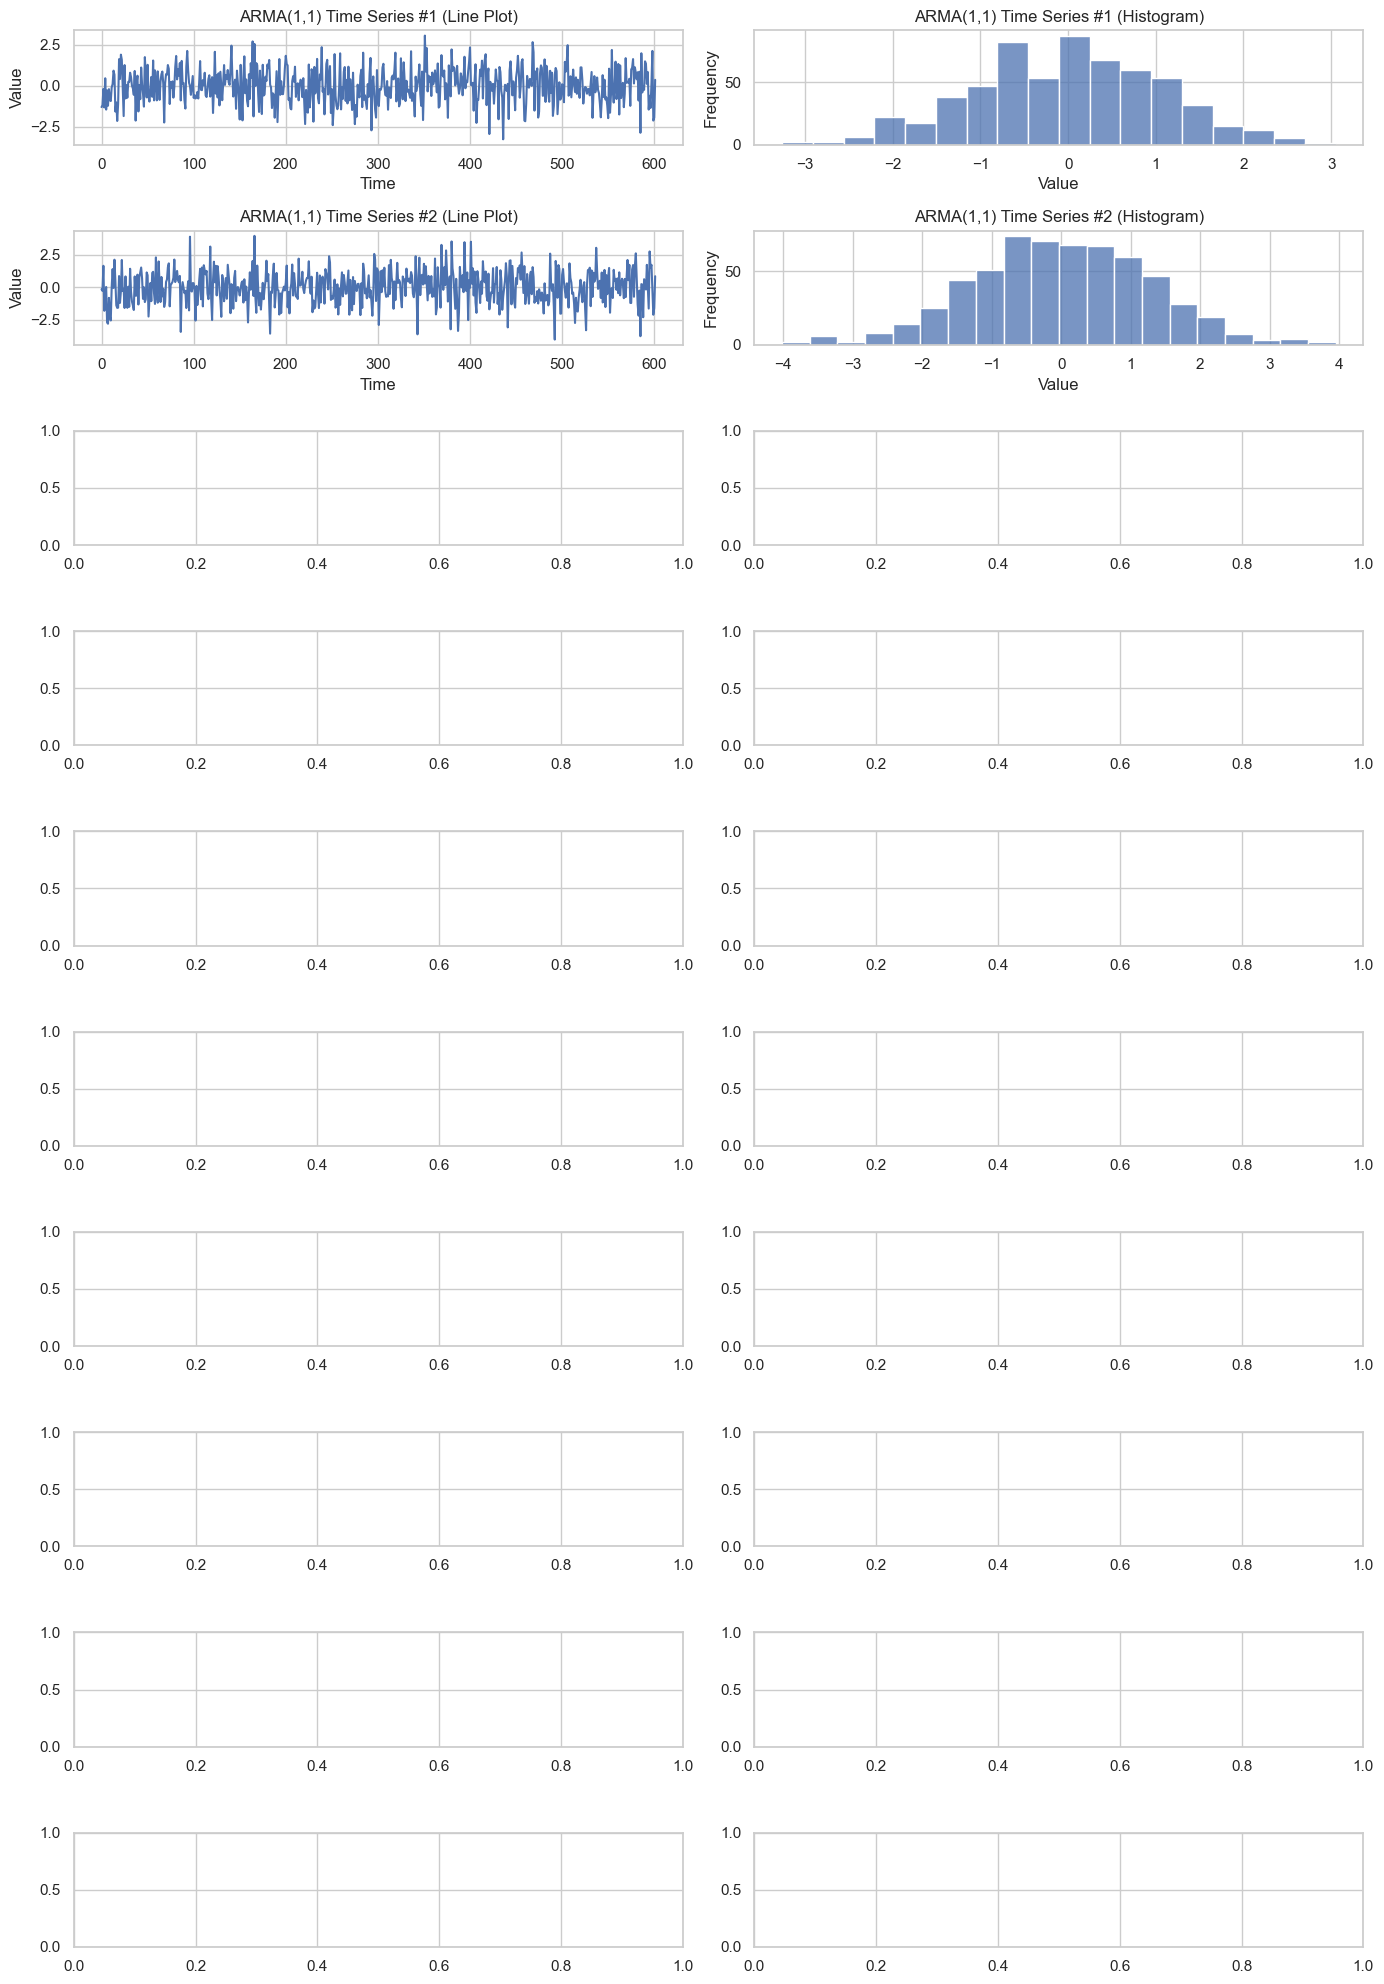

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")


fig, axs = plt.subplots(10, 2, figsize=(14, 20))


for i, series in enumerate(residuals.T):
    #绘制时间序列线图
    axs[i, 0].plot(series)
    axs[i, 0].set_title(f"ARMA(1,1) Time Series #{i+1} (Line Plot)")
    axs[i, 0].set_xlabel("Time")
    axs[i, 0].set_ylabel("Value")

    #绘制时间序列直方图
    sns.histplot(series, kde=False, ax=axs[i, 1])

    axs[i, 1].set_title(f"ARMA(1,1) Time Series #{i+1} (Histogram)")
    axs[i, 1].set_xlabel("Value")
    axs[i, 1].set_ylabel("Frequency")


plt.tight_layout()
plt.show()